<a href="https://colab.research.google.com/github/marisbotero/style-transfer-the-time-machine/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⭐La máquina del tiempo 🐥🎨

Volver al pasado para celebrar el futuro.Contemos y pintemos historias, nuestra historia.Y es que es parte  del ritual amoroso de la gratitud: aquello que vuelve a pasar por el alma una y otra vez, y que nunca se olvida. 🧡





¿Alguna vez quisiste poder pintar como Picasso o Van Gogh? ¿Y si tus fotos tienes el estilo de los mejores pintores?

## 💫 transferencia de estilo neural 

💚Esta es una técnica de optimización utilizada para tomar dos imágenes (una imagen de contenido y una imagen de referencia de estilo (como una obra de arte de un pintor famoso)) y combinarlas para que la imagen de salida se vea  "pintada" en el estilo de la imagen de referencia de estilo.



Esto se implementa optimizando la imagen de salida para que coincida con las estadísticas de contenido de la imagen de contenido y las estadísticas de estilo de la imagen de referencia de estilo. Estas estadísticas se extraen de las imágenes mediante una red convolucional.

## Importar las librerias

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [4]:
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

     |████████████████████████████████| 348.9MB 40kB/s 
     |████████████████████████████████| 3.1MB 30.1MB/s 
     |████████████████████████████████| 501kB 38.4MB/s 


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools


Descargamos las imágenes y elejimos una imagen de estilo y una imagen de contenido:

In [7]:
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


## Visualiza la entrada
Definimos una función para cargar una imagen y limitamos su dimensión máxima a 512 píxeles.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Creamos una función simple para mostrar una imagen:

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

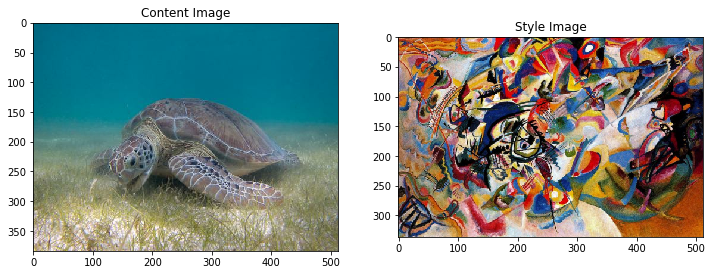

In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Definir representaciones de contenido y estilo.
Usamos las capas intermedias del modelo para obtener el contenido y las representaciones de estilo de la imagen. A partir de la capa de entrada de la red, las primeras activaciones de capa representan características de bajo nivel como bordes y texturas. A medida que avanza por la red, las pocas capas finales representan características de nivel superior: partes de objetos como ruedas u ojos. En este caso, está utilizando la arquitectura de red VGG19, una red de clasificación de imágenes previamente entrenada. Estas capas intermedias son necesarias para definir la representación del contenido y el estilo de las imágenes. Para una imagen de entrada, intente hacer coincidir las representaciones de destino de contenido y estilo correspondientes en estas capas intermedias.


In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 13s 0us/step


TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('loggerhead', 0.7429765),
 ('leatherback_turtle', 0.11357851),
 ('hermit_crab', 0.054412737),
 ('terrapin', 0.039235555),
 ('mud_turtle', 0.012614685)]

Ahora cargamos  VGG19 sin el encabezado de clasificación y enumeramos
los nombres de capa

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 2s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Capas intermedias para estilo y contenido
¿por qué estos resultados intermedios dentro de nuestra red de clasificación de imágenes previamente capacitada nos permiten definir representaciones de estilo y contenido?

En un nivel alto, para que una red realice la clasificación de imágenes (para lo cual esta red ha sido entrenada), debe comprender la imagen. Esto requiere tomar la imagen en bruto como píxeles de entrada y construir una representación interna que convierta los píxeles de la imagen en bruto en una comprensión compleja de las características presentes en la imagen.

Esta es también una razón por la cual las redes neuronales convolucionales pueden generalizarse bien: son capaces de capturar las variaciones y definir características dentro de las clases (por ejemplo, gatos contra perros) que son independientes del ruido de fondo y otras molestias. Por lo tanto, en algún lugar entre donde la imagen en bruto se alimenta al modelo y la etiqueta de clasificación de salida, el modelo sirve como un extractor de características complejas. Al acceder a las capas intermedias del modelo, puede describir el contenido y el estilo de las imágenes de entrada.

## Construyamos el modelo
Las redes en *tf.keras.applications*  están diseñadas para que pueda extraer fácilmente los valores de la capa intermedia utilizando la API funcional de Keras.

Para definir un modelo utilizando la API funcional, especifique las entradas y salidas:

modelo = Modelo (entradas, salidas)


In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [17]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



## Calcular estilo
El contenido de una imagen está representado por los valores de los mapas de entidades intermedias.

Resulta que el estilo de una imagen se puede describir por los medios y las correlaciones entre los diferentes mapas de características. Calcule una matriz de Gram que incluya esta información tomando el producto externo del vector de características consigo mismo en cada ubicación y promediando ese producto externo en todas las ubicaciones. 

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.03488167
    max:  26723.25
    mean:  780.96204

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95840.18
    mean:  11674.933

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  296185.9
    mean:  7241.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3164085.2
    mean:  104884.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  66307.836
    mean:  650.05994

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.0782
    mean:  8.983593


## Gradiente descendente: 
Con este extractor de estilo y contenido, ahora se puede implementar el algoritmo de transferencia de estilo. se calcula el error cuadrado medio para la salida de la imagen en relación con cada objetivo, luego tome la suma ponderada de estas pérdidas.


In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
image = tf.Variable(content_image)

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight=1e-2
content_weight=1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

W0817 21:33:02.618720 140347901106048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


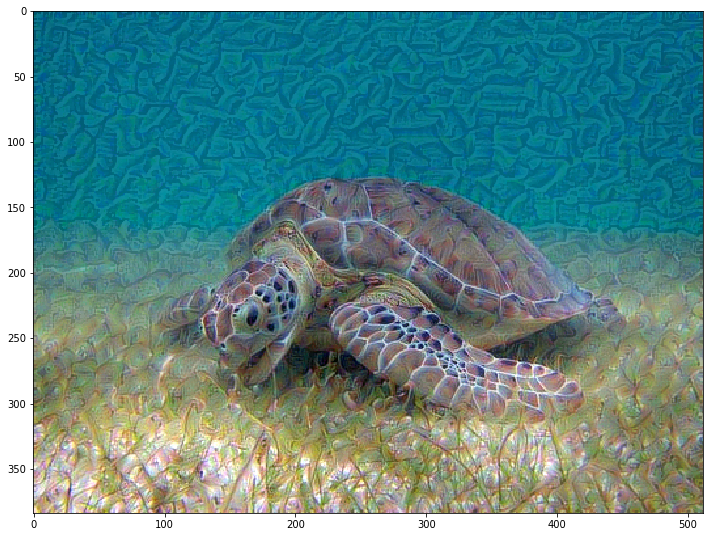

In [28]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

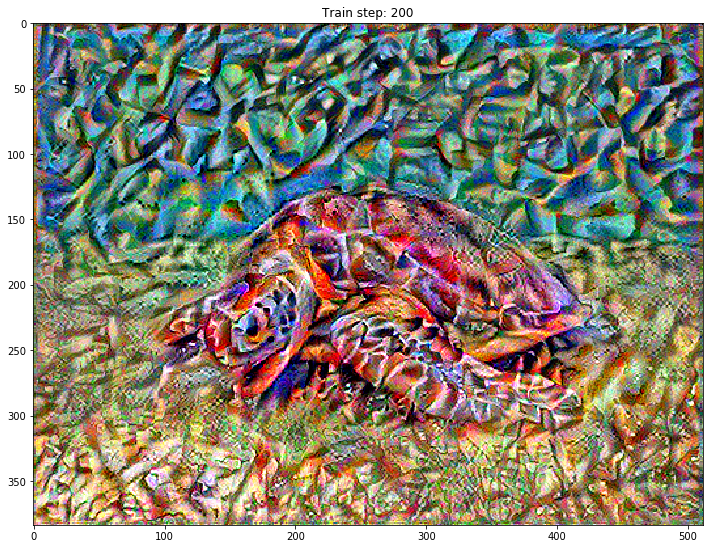

.................................................

In [0]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))